In [97]:
import cv2
import os
!pip install Keras==2.2.4
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import coremltools
import pickle

### Path


In [98]:
path = "-------------/Downloads/Kaggle-7000/data"

### Preprocessing

In [99]:
def preprocess_data(path, category_0, category_1):
    ##------- 1 
    path = path
    categories = [category_0, category_1]
    #our classes
    classes = [0, 1]
    labeled_data = dict(zip(categories, classes))
    #print(labeled_data)
    
    ##------- 2 
    training_data = []
    #for each folder (0_without_mask, 1_with_mask)
    for category in categories:
        classes_path = os.path.join(path, category)
        #get image names for each (0_without_mask, 1_with_mask)
        image_names = os.listdir(classes_path)

        for image_name in image_names:
            try: 
                each_image_path = os.path.join(classes_path, image_name)
                #convert image to ARRAY
                img = cv2.imread(each_image_path, cv2.COLOR_BGR2RGB)
                resized_image = cv2.resize(img, (256, 256))
                normalized_image = resized_image / 255.
                training_data.append([normalized_image, labeled_data[category]])
            except Exception as e: 
                print("error")
                
    ##------- 3           
    random.shuffle(training_data)
    return training_data

(<matplotlib.image.AxesImage at 0x7fa767fef748>, 0)

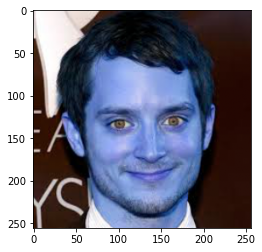

In [5]:
def plot_image(image):
    return plt.imshow(training_data[image][0]), training_data[image][1]

plot_image(400)

### Train, test

In [104]:
def X_Y_data(training_data):
    X = []
    y = []

    for features,label in training_data:
        X.append(features)
        y.append(int(label))

    X = np.array(X)#.reshape(-1, 256, 256, 3)
    y = np.array(y)
    return X, y

### Training

In [ ]:
network = Sequential()

network.add(Convolution2D(32, kernel_size=(3, 3), strides=1, input_shape=(256, 256, 3), activation='relu'))
#network.add(Convolution2D(32, kernel_size=(3, 3), strides=1, activation='relu'))
network.add(MaxPooling2D((2, 2)))
#network.add(Dropout(0.2))

network.add(Convolution2D(64, kernel_size=(3, 3), strides=1, activation='relu'))
#network.add(Convolution2D(64, kernel_size=(3, 3), strides=1, activation='relu'))
network.add(MaxPooling2D((2, 2)))
#network.add(Dropout(0.25))

network.add(Convolution2D(64, kernel_size=(3, 3), strides=1, activation='relu'))
#network.add(Convolution2D(64, kernel_size=(3, 3), strides=1, activation='relu'))
network.add(MaxPooling2D((2, 2)))
#network.add(Dropout(0.25))

network.add(Convolution2D(128, kernel_size=(3, 3), strides=1, activation='relu'))
network.add(MaxPooling2D((2, 2)))
#network.add(Dropout(0.3))

network.add(Flatten())
network.add(Dense(256, activation = 'relu'))
network.add(Dense(1, activation = 'sigmoid'))

checkpoint_path = os.path.join("-------------/Desktop/Final_project/Mask_Detection/Datasets/Kaggle-7000", "weightsDropout.best.hdf5")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
callbacks_list = [checkpoint, es]

network.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [58]:
model = network.fit(X, y, batch_size=64, epochs=5, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/5
95/95 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9823
Epoch 00001: val_accuracy did not improve from 0.96625
95/95 [==============================] - 170s 2s/step - loss: 0.0507 - accuracy: 0.9823 - val_loss: 0.1417 - val_accuracy: 0.9629
Epoch 2/5
95/95 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9866
Epoch 00002: val_accuracy did not improve from 0.96625
95/95 [==============================] - 154s 2s/step - loss: 0.0344 - accuracy: 0.9866 - val_loss: 0.1369 - val_accuracy: 0.9636
Epoch 3/5
95/95 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9894
Epoch 00003: val_accuracy did not improve from 0.96625
95/95 [==============================] - 153s 2s/step - loss: 0.0311 - accuracy: 0.9894 - val_loss: 0.1786 - val_accuracy: 0.9583
Epoch 4/5
95/95 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9914
Epoch 00004: val_accuracy did not improve from 0.96625
95/95 [===========

### Accuracy, Loss

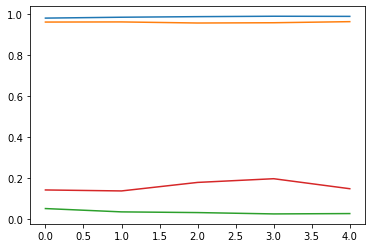

In [87]:
plt.plot(model.history['accuracy'], label='accuracy')
plt.plot(model.history['val_accuracy'], label='val_accuracy')
plt.plot(model.history['loss'], label='loss')
plt.plot(model.history['val_loss'], label='val_loss')
plt.show()

### New data for test

In [105]:
test_data = preprocess_data("-------------/Downloads/DataFlairData", "0-without_mask", "1-with_mask")
X_test, y_test = X_Y_data(test_data)

error
error


In [108]:
test_loss, test_acc = network.evaluate(X_test, y_test, batch_size=32)

48/48 [==============================] - 10s 218ms/step - loss: 0.0294 - accuracy: 0.9920


### Convert to CoreML for iOS

In [112]:
network.save("mask_detection_model_96625%.h5")
coreml_model = coremltools.convert("mask_detection_model_96625%.h5", input_names=['input'], output_names=['output'],
                                    is_bgr=True, image_scale=1/255, class_labels=[0, 1])

Translating MIL ==> MLModel Ops: 100%|██████████| 74/74 [00:00<00:00, 509.98 ops/s]


In [113]:
coreml_model.save("mask_detection_model_96625%.mlmodel")